In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from albumentations import *
from torchvision import transforms
from torch.utils.data import DataLoader
from glob import glob
import segmentation_models_pytorch as smp
import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm 
import logging
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
import tensorflow_datasets as tfds

In [8]:
%load_ext autoreload
%autoreload 2

import utils_rs
import dataset_rs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
len(masks_array)

170

In [37]:
unqs= []
for map in masks_array:
    for m in np.unique(map):
        unqs.append( m)
unqs_ = set(unqs)

In [38]:
unqs_

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [28]:
unqs

[array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2], dtype=uint8),
 array([0, 1, 2, 3, 4], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2, 3], dtype=uint8),
 array([0, 1, 2, 3, 4], dtype=uint8),
 array([0, 1, 2, 3], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2, 3], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2, 3], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([0, 1, 2, 3], dtype=uint8),
 array([0, 1, 2, 3], dtype=uint8),
 array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2], dtype=uint8),
 array([0, 1, 2, 3, 4], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2, 3, 4], dtype=uint8),
 array([0, 1, 2], dtype=uint8),
 arr

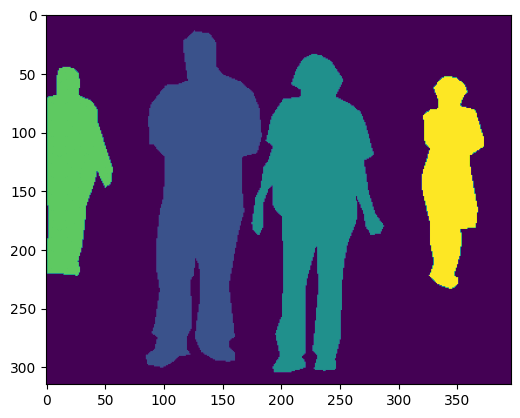

In [36]:
plt.imshow(masks_array[7])

In [12]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch:
        
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0)
    targets = torch.stack(targets, dim=0)

    return images, targets

In [13]:
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

tr_dataset = building_dataset(img_dir=img_path, mask_dir=mask_path, phase="train")
val_dataset = building_dataset(img_dir=img_path,mask_dir=mask_path, phase="val")

In [14]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet152",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=16,                      # model output channels (number of classes in your dataset)
)

In [15]:
tr_dataset.__getitem__(0)[0].shape

torch.Size([3, 224, 224])

In [16]:
img = tr_dataset.__getitem__(0)[0]
img = img.unsqueeze(0)

target = tr_dataset.__getitem__(0)[1]
target = target.unsqueeze(0)

model.eval()
pred = model(img)

loss = nn.CrossEntropyLoss(reduction='mean')
output_ = loss(pred,target)

In [17]:
output_

tensor(2.8170, grad_fn=<NllLoss2DBackward0>)

In [18]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction="mean") # "mean" or "sum"

    def __call__(self, pred, target):
        # cross-entropy
        loss1 = self.CE_loss(pred, target)
        
        # dice-coefficient
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2) 
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        loss2 = self._get_dice_loss(onehot_pred, onehot_target)
        
        # total loss
        loss = loss1 + loss2

        # dice score
        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return loss, dice_coefficient

    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2 * set_inter
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff

    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)

    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch

    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [19]:
unet_metric = UNet_metric(16)

In [20]:
unet_metric( pred, target)

(tensor(3.8170, grad_fn=<AddBackward0>), tensor(0.))

In [22]:
#-- args
BATCH_SIZE = 4


#-- logger
logging.basicConfig(filename='./01.log/model_v1.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#-- datasets 
train_dataset = building_dataset(img_dir=img_path, mask_dir=mask_path, phase="train" )
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

valid_dataset = building_dataset(img_dir=img_path,mask_dir=mask_path, phase="val" )
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

data_loader= {}
data_loader["train"] = train_loader
data_loader["valid"] = valid_loader

In [23]:
len(train_loader)

7381

In [28]:
len(glob(os.path.join(img_path,"*.png"))) / 4

7380.5

In [33]:
#-- args
import datetime

EXEC_VER = 5 
BATCH_SIZE = 8
DEVICE = "cuda:0"

#-- logger
# Set up logging
log_filename = datetime.datetime.now().strftime(f'./01.log/ver_{EXEC_VER}_%Y-%m-%d_%H-%M-%S.log')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
handler = logging.FileHandler(log_filename)
logger.addHandler(handler)

#-- datasets 
train_dataset = building_dataset(img_dir=img_path, mask_dir=mask_path, phase="train" )
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

valid_dataset = building_dataset(img_dir=img_path,mask_dir=mask_path, phase="val" )
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

data_loader= {}
data_loader["train"] = train_loader
data_loader["valid"] = valid_loader

#-- model 
model = smp.DeepLabV3Plus(
    encoder_name="resnet152",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=16,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)

#-- loss 
criterion = nn.CrossEntropyLoss()

#-- optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# run
epochs = 999
iteration = 0
total_loss = 0

for epoch in range(epochs):
    
    iteration = 0
    epoch_running_loss = 0 
    
    #tqdm_iterator = tqdm(data_loader["train"], desc=f"Epoch {epoch}")
    
    for index, data in enumerate(data_loader["train"]):
        
        imgs, masks = data
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        # opt
        optimizer.zero_grad()
        
        # runs
        outputs = model(imgs)
        
        # loss
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        # stat
        epoch_running_loss += loss.item()

        # log
        logger.info(f"epoch : {epoch} iter : {index} loss: {loss:.8f}")
        log = {'loss': f'{loss / 10:.8f}' }
        #wandb.log(log)

        log_iter = 100
        
        if (index % log_iter) == 0:    # print every 2000 mini-batches
            print(f"epoch : {epoch} , iter : {index} , total_iter : {len(data_loader['train'])} , running_loss : {epoch_running_loss / (index +1)}")
        
    
    #-- save 
    save_path = f"./02.ckpts/model_ver_{EXEC_VER}_{epoch + 1}.pt"
    torch.save(model.state_dict(), save_path)

epoch : 0 , iter : 0 , total_iter : 3691 , running_loss : 3.0274264812469482
epoch : 0 , iter : 100 , total_iter : 3691 , running_loss : 2.888401376138819
epoch : 0 , iter : 200 , total_iter : 3691 , running_loss : 2.7335412431119095
epoch : 0 , iter : 300 , total_iter : 3691 , running_loss : 2.53403531990178
epoch : 0 , iter : 400 , total_iter : 3691 , running_loss : 2.3427370724238066
epoch : 0 , iter : 500 , total_iter : 3691 , running_loss : 2.1750047214016943
epoch : 0 , iter : 600 , total_iter : 3691 , running_loss : 2.0314430680727207
epoch : 0 , iter : 700 , total_iter : 3691 , running_loss : 1.9096435046570108
epoch : 0 , iter : 800 , total_iter : 3691 , running_loss : 1.8031475929434082
epoch : 0 , iter : 900 , total_iter : 3691 , running_loss : 1.7076176323583732
epoch : 0 , iter : 1000 , total_iter : 3691 , running_loss : 1.6232063040866718
epoch : 0 , iter : 1100 , total_iter : 3691 , running_loss : 1.547762386480534
epoch : 0 , iter : 1200 , total_iter : 3691 , running_lo